In [ ]:
# Connecting to Google drive in order to store the weights of the agents HDF5 files.
from google.colab import drive

drive.mount('/content/gdrive');

Mounted at /content/gdrive


## Install Dependencies

In [ ]:
pip install wfdb wget tqdm biosppy imbalanced-learn seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 8.9 MB/s 
     |████████████████████████████████| 1.5 MB 49.6 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=68702ba03325c080364076995b98ced4c640a8a64542f357c840fd2b29520c6d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
  Created wheel for biosppy: filename=biosppy-0.8.0-py2.py3-none-any.whl size=100176 sha256=42cb4278851f766dabc2f34cc8a47ef35f6115a15b798bf7aba30843ea0d4cd8
  Stored in directory: /root/.cache/pip/wheels/32/17/9d/77adbf0db713546eaa1c7a1480b2dce91fa724a133115dc20c
Successfully built wget biosppy


In [ ]:
!pip uninstall matplotlib --yes
!pip install matplotlib==3.1.3 

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 8.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.0.0 requires matplotlib<4.0.0,>=3.2.2, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Importing Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import wget
import math
import zipfile
import wfdb as wf
import os
import pickle
import sys
import datetime
import cv2
from scipy import signal
from scipy.signal import resample
from scipy.signal import find_peaks
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

## Extracting Data

In [ ]:
module = os.path.abspath('/content/gdrive/MyDrive/WESAD/')
if module not in sys.path:
    sys.path.append(module)
from DataManager import DataManager

## Data Preprocessing

In [ ]:
# config
debug = True;

In [ ]:
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [ ]:
test_subject = [2]
rest_subjects = [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [ ]:
def generateData(subject_ids):
    data = DataManager()
    all_subject_data = np.array([]);
    all_subject_labels = np.array([]);

#     subject_ids = [2, 3]

    for subject_id in subject_ids:
        if(debug): print("Processing subject id: ", subject_id);
        subject = data.load(subject_id)


        if(debug):
            print('baseline: ', subject[0], '\nstress: ', subject[1], '\namusement: ', subject[2], '\nbase_label: ', subject[3], '\nstress_label: ', subject[4], '\namuse_label: ', subject[5])

        ecg_base = subject[0]
        ecg_stress = subject[1]
        ecg_amusement = subject[2]

        base_label = subject[3]
        stress_label = subject[4]
        amuse_label = subject[5]

        ecg_base_T = ecg_base.T
        ecg_stress_T = ecg_stress.T
        ecg_amusement_T = ecg_amusement.T

        ecg_base_data = ecg_base_T[0]
        ecg_stress_data = ecg_stress_T[0]
        ecg_amusement_data = ecg_amusement_T[0]

        ecg_base_label =  base_label.T
        ecg_stress_label  = stress_label.T
        ecg_amusement_label  = amuse_label.T

        if(debug):
            print('ecg_base_data:', ecg_base_data)
            print('ecg_stress_data:', ecg_stress_data)
            print('ecg_amusement_data:', ecg_amusement_data)

            print('ecg_base_label:', ecg_base_label)
            print('ecg_stress_label:', ecg_stress_label)
            print('ecg_amusement_label:', ecg_amusement_label)


        base_secs = len(ecg_base_data) // 700 # Number of seconds in signal X
        base_samps = int(base_secs * 256 )    # Number of samples to downsample
        base_down = signal.resample(ecg_base_data, base_samps)


        stress_secs = len(ecg_stress_data) // 700 # Number of seconds in signal X
        stress_samps = int(stress_secs * 256 )    # Number of samples to downsample
        stress_down = signal.resample(ecg_stress_data, stress_samps)


        amuse_secs = len(ecg_amusement_data) // 700 # Number of seconds in signal X
        amuse_samps = int(amuse_secs * 256 )    # Number of samples to downsample
        amuse_down = signal.resample(ecg_amusement_data, amuse_samps)

    #     heart_beat_base = np.array_split(base_down, 256)
    #     heart_beat_stress = np.array_split(stress_down, 256)
    #     heart_beat_amuse = np.array_split(amuse_down, 256)

        window_size = 256
        window_shift = 256

        heart_beat_base = []
        for i in range(0,len(base_down) - window_size,window_shift):
            heart_beat_base.append(base_down[i:window_size + i])
        heart_beat_base.pop()
    #     heart_beat_base = np.array(list(heart_beat_base[:]), dtype=float)

        heart_beat_stress = []
        for i in range(0,len(stress_down) - window_size,window_shift):
            heart_beat_stress.append(stress_down[i:window_size + i])
        heart_beat_stress.pop()
    #     heart_beat_stress = np.array(list(heart_beat_stress[:]), dtype=float)

        heart_beat_amuse = []
        for i in range(0,len(amuse_down) - window_size,window_shift):
            heart_beat_amuse.append(amuse_down[i:window_size + i])
        heart_beat_amuse.pop()
    #     heart_beat_amuse = np.array(list(heart_beat_amuse[:]), dtype=float)


        for idx, idxval in enumerate(heart_beat_base):
            heart_beat_base[idx] = (heart_beat_base[idx] - heart_beat_base[idx].min()) / heart_beat_base[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_base[idx] = np.append(heart_beat_base[idx], 0.0) #Baseline = 0

        for idx, idxval in enumerate(heart_beat_stress):
            heart_beat_stress[idx] = (heart_beat_stress[idx] - heart_beat_stress[idx].min()) / heart_beat_stress[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_stress[idx] = np.append(heart_beat_stress[idx], 1.0) #Stress = 1    

        for idx, idxval in enumerate(heart_beat_amuse):
            heart_beat_amuse[idx] = (heart_beat_amuse[idx] - heart_beat_amuse[idx].min()) / heart_beat_amuse[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_amuse[idx] = np.append(heart_beat_amuse[idx], 2.0) #Amusement = 2

    #     print("heart_beat_base:", len(heart_beat_base[0]), len(heart_beat_base[-2]), len(heart_beat_base[-1]))
    #     print("heart_beat_stress:", len(heart_beat_stress[0]), len(heart_beat_stress[-1]))
    #     print("heart_beat_amuse:", len(heart_beat_amuse[0]), len(heart_beat_amuse[-1]))

        heart_beat_all = np.concatenate((heart_beat_base, heart_beat_stress, heart_beat_amuse), axis=0)
        subject_data = np.array(list(heart_beat_all[:]), dtype=float)


        if(all_subject_data.size == 0):
            all_subject_data = subject_data
        else:
            if(subject_data.size != 0):
                all_subject_data = np.concatenate((all_subject_data, subject_data), axis=0)

        print("New data shape", subject_data.shape, "Total Shape: ", all_subject_data.shape)
        
    #SMOTE to balance the data
    df_final_data_X = pd.DataFrame(data=all_subject_data[:, :-1])
    df_final_data_Y = pd.DataFrame(data=all_subject_data[:,-1])

    smote = SMOTE(sampling_strategy='not majority')
    X_sm, y_sm = smote.fit_resample(df_final_data_X, df_final_data_Y)
    
    return X_sm, y_sm

## Data Generation - Train

In [ ]:
train_data, train_labels = generateData(rest_subjects)

Processing subject id:  2
Loading data for S2
baseline:  [[0.03094482]
 [0.03364563]
 [0.03300476]
 ...
 [0.35952759]
 [0.38768005]
 [0.41500854]] 
stress:  [[-0.01167297]
 [-0.0015564 ]
 [ 0.02238464]
 ...
 [ 0.00361633]
 [ 0.00352478]
 [ 0.00032043]] 
amusement:  [[-0.09645081]
 [-0.09159851]
 [-0.08596802]
 ...
 [ 0.05731201]
 [ 0.06298828]
 [ 0.06216431]] 
base_label:  [1 1 1 ... 1 1 1] 
stress_label:  [2 2 2 ... 2 2 2] 
amuse_label:  [3 3 3 ... 3 3 3]
ecg_base_data: [0.03094482 0.03364563 0.03300476 ... 0.35952759 0.38768005 0.41500854]
ecg_stress_data: [-0.01167297 -0.0015564   0.02238464 ...  0.00361633  0.00352478
  0.00032043]
ecg_amusement_data: [-0.09645081 -0.09159851 -0.08596802 ...  0.05731201  0.06298828
  0.06216431]
ecg_base_label: [1 1 1 ... 1 1 1]
ecg_stress_label: [2 2 2 ... 2 2 2]
ecg_amusement_label: [3 3 3 ... 3 3 3]
New data shape (2115, 257) Total Shape:  (2115, 257)
Processing subject id:  3
Loading data for S3
baseline:  [[-0.19184875]
 [-0.18663025]
 [-0.179

In [ ]:
train_labels.value_counts()

0.0    16408
1.0    16408
2.0    16408
dtype: int64

In [ ]:
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train data shape: (49224, 256)
Train labels shape: (49224, 1)
Dimension: 2


In [ ]:
train_labels = pd.DataFrame(train_labels).to_numpy()
train_labels = train_labels.reshape(-1)

In [ ]:
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train labels shape: (49224,)
Dimension: 1


## Train and Validation data split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.3, random_state=42)

In [ ]:
#Reshape train and validation data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

In [ ]:
print('size of X_train:', X_train.shape)
print('size of X_val:', X_val.shape)

print('size of y_train:', y_train.shape)
print('size of y_val:', y_val.shape)

print('Train:', Counter(y_train), '\nVal:', Counter(y_val))

size of X_train: (34456, 256, 1)
size of X_val: (14768, 256, 1)
size of y_train: (34456,)
size of y_val: (14768,)
Train: Counter({1.0: 11509, 2.0: 11474, 0.0: 11473}) 
Val: Counter({0.0: 4935, 2.0: 4934, 1.0: 4899})


## Data Generation - Test

In [ ]:
test_data, test_labels = generateData(test_subject)

Processing subject id:  15
Loading data for S15
baseline:  [[-0.17816162]
 [-0.18022156]
 [-0.18333435]
 ...
 [ 0.0015564 ]
 [-0.00114441]
 [-0.00457764]] 
stress:  [[-0.09370422]
 [-0.08647156]
 [-0.08335876]
 ...
 [-0.03753662]
 [-0.02476501]
 [-0.01661682]] 
amusement:  [[-0.00105286]
 [-0.00032043]
 [ 0.00151062]
 ...
 [-0.15348816]
 [-0.15248108]
 [-0.15252686]] 
base_label:  [1 1 1 ... 1 1 1] 
stress_label:  [2 2 2 ... 2 2 2] 
amuse_label:  [3 3 3 ... 3 3 3]
ecg_base_data: [-0.17816162 -0.18022156 -0.18333435 ...  0.0015564  -0.00114441
 -0.00457764]
ecg_stress_data: [-0.09370422 -0.08647156 -0.08335876 ... -0.03753662 -0.02476501
 -0.01661682]
ecg_amusement_data: [-0.00105286 -0.00032043  0.00151062 ... -0.15348816 -0.15248108
 -0.15252686]
ecg_base_label: [1 1 1 ... 1 1 1]
ecg_stress_label: [2 2 2 ... 2 2 2]
ecg_amusement_label: [3 3 3 ... 3 3 3]
New data shape (2227, 257) Total Shape:  (2227, 257)


In [ ]:
test_labels.value_counts()

0.0    1173
1.0    1173
2.0    1173
dtype: int64

In [ ]:
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Dimension:", test_labels.ndim)

Test data shape: (3519, 256)
Test labels shape: (3519, 1)
Dimension: 2


In [ ]:
test_labels = pd.DataFrame(test_labels).to_numpy()
y_test = test_labels.reshape(-1)

In [ ]:

print("Test labels shape:", y_test.shape)
print("Dimension:", y_test.ndim)

Test labels shape: (3519,)
Dimension: 1


In [ ]:
#Reshape test data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_test = np.array(test_data).reshape(test_data.shape[0], test_data.shape[1], 1)

In [ ]:
print('size of X_test:', X_test.shape)
print('size of y_test:', y_test.shape)

print('Test:', Counter(y_test))

size of X_test: (3519, 256, 1)
size of y_test: (3519,)
Test: Counter({0.0: 1173, 1.0: 1173, 2.0: 1173})


In [ ]:
# df_final_data_X = pd.DataFrame(data=all_subject_data[:, :-1])
# df_final_data_Y = pd.DataFrame(data=all_subject_data[:,-1])

# smote = SMOTE(sampling_strategy='not majority')
# X_sm, y_sm = smote.fit_resample(df_final_data_X, df_final_data_Y)
# y_sm.value_counts()

In [ ]:
# Reshape train and test data to (n_samples, 256, 1), where each sample is of size (256, 1)
# X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
# X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

## 1D CNN Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, MaxPool1D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import initializers

In [ ]:
cnn_model = tf.keras.models.Sequential()
cnn_model.add(Conv1D(filters=5, kernel_size=(5,), padding='same',  activation='relu', input_shape = (X_train.shape[1],1), kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=10, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=10, kernel_size=(4,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128, kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(Dense(units = 3, activation='softmax'))

In [ ]:
epochs=50
batch_size = 32

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.005
   drop = 0.6
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

lrate = LearningRateScheduler(step_decay)

In [ ]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [ ]:
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

In [ ]:
opt = tf.keras.optimizers.SGD( learning_rate=0.0, momentum=0.6, nesterov=False)

cnn_model.compile(optimizer= opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 256, 5)            30        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 128, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 10)           260       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 64, 10)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 10)            410       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 32, 10)           0

In [ ]:
history = cnn_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val), callbacks=callbacks_list, verbose=2)

Epoch 1/50
1077/1077 - 17s - loss: 1.8223 - accuracy: 0.3322 - val_loss: 1.7468 - val_accuracy: 0.3342 - lr: 0.0050 - 17s/epoch - 16ms/step
Epoch 2/50
1077/1077 - 5s - loss: 1.6820 - accuracy: 0.3317 - val_loss: 1.6212 - val_accuracy: 0.3341 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 3/50
1077/1077 - 5s - loss: 1.5690 - accuracy: 0.3307 - val_loss: 1.5199 - val_accuracy: 0.3342 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 4/50
1077/1077 - 5s - loss: 1.4779 - accuracy: 0.3341 - val_loss: 1.4384 - val_accuracy: 0.3342 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 5/50
1077/1077 - 5s - loss: 1.4045 - accuracy: 0.3319 - val_loss: 1.3724 - val_accuracy: 0.3341 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 6/50
1077/1077 - 5s - loss: 1.3452 - accuracy: 0.3317 - val_loss: 1.3196 - val_accuracy: 0.3342 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 7/50
1077/1077 - 5s - loss: 1.2975 - accuracy: 0.3290 - val_loss: 1.2767 - val_accuracy: 0.3317 - lr: 0.0050 - 5s/epoch - 5ms/step
Epoch 8/50
1077/1077 - 5s - loss: 1.25

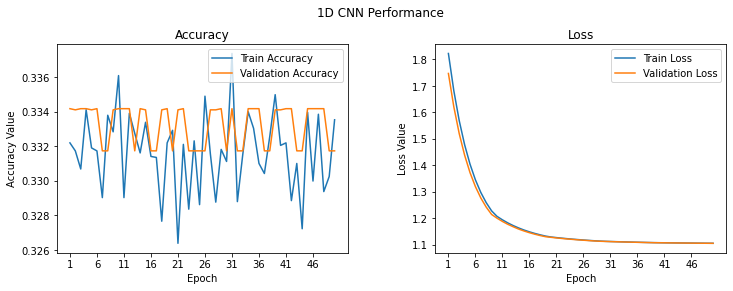

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('1D CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
cnn_model.evaluate(X_test, y_test)

110/110 [==============================] - 0s 3ms/step - loss: 1.1054 - accuracy: 0.3333


[1.1054459810256958, 0.3333333432674408]

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = cnn_model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.54      0.76      0.63      1196
         1.0       1.00      0.30      0.46      1196
         2.0       0.29      0.38      0.33      1196

    accuracy                           0.48      3588
   macro avg       0.61      0.48      0.48      3588
weighted avg       0.61      0.48      0.48      3588

